In [76]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays, StaticArrays, BenchmarkTools, Test

function smoothstep!(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 500.0 # μs
recordtimes = 500
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 0 # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Nq = length(ψ_sc0.quantum)
Nc = length(ψ_sc0.classical)
Ntot = Nq + Nc
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)
# u0 = zeros(ComplexF64, Ntot)
# semiclassical.recast!(u0, ψ_sc0)
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel!(t) = 1.1*smoothstep!(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C0 = gc*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
C!(t) = grel!(t)*C0

H0T1 = ωz*Sz
H0T2 = (gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
function H0!(t)
    return H0T1 - H0T2*(grel!(t))^2
end
function H_nl!(ψ,t)
    Ct = C!(t)
    return im * expect(dagger(Ct), normalize(ψ)) * Ct - 0.5im * dagger(Ct) * Ct - 0.5im * expect(dagger(Ct), normalize(ψ)) * expect(Ct, normalize(ψ)) * idOp
end
fdet_heterodyne!(t, ψ) = H0!(t) + H_nl!(ψ, t)
function fst_heterodyne!(t, ψ)
    Ct = C!(t)
    return [(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2), im*(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2)]
end

function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne!, stateG.quantum, t)
    dstateG.classical[1] = expect(C!(t), stateG.quantum)
    semiclassical.recast!(du, dstateG)
end

num_noise = length(fst_heterodyne!(0., ψ_sc0.quantum))
noise_prototype = zeros(ComplexF64, (Ntot, num_noise))

function g!(du, u, p, t)
    semiclassical.recast!(stateG, u)
    dx = @view du[1:Nq,:]
    stochastic.dschroedinger_stochastic(dx, t, stateG.quantum, fst_heterodyne!, dstateG.quantum, num_noise)
    du[Nq+1, 1] = 1.0/sqrt(2)
    du[Nq+1, 2] = 1.0im/sqrt(2)
    du
end

Base.@pure pure_inference(fout,T) = Core.Compiler.return_type(fout, T)

function fout(t, state)
    copy(state)
end
function fout_(x, t, integrator)
    semiclassical.recast!(stateG,x)
    copy(stateG)
end

out_type = pure_inference(fout, Tuple{eltype(tspan),typeof(ψ_sc0)})
out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                         save_everystep=true,
                                         save_start = false,
                                         tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))

sde_func = SDEFunction(f!,g!;)

W = WienerProcess(0.0, zeros(2), zeros(2))
prob = SDEProblem(sde_func, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=W)
sol1 = solve(prob, RKMilGeneral(;ii_approx=IICommutative());
            adaptive=false,
            dt=1//2^(7),
            callback=scb, seed=seed, save_noise=true)

tout_fine = copy(out.t)
psi_t_fine = copy(out.saveval)

W2 = NoiseWrapper(sol1.W)
out2 = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out2,saveat=tspan,
                                         save_everystep=true,
                                         save_start = false,
                                         tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
prob2 = SDEProblem(sde_func, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=W2)
sol2 = solve(prob2, RKMilGeneral(;ii_approx=IICommutative());
            adaptive=false,
            dt=1//2^(6),
            callback=scb, seed=seed, save_noise=true)
tout_course = copy(out2.t)
psi_t_course = copy(out2.saveval);

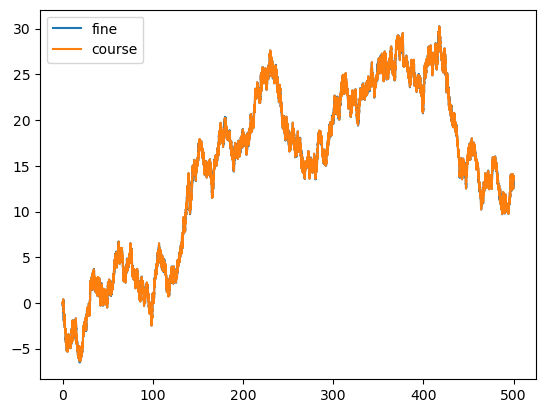

PyObject <matplotlib.legend.Legend object at 0x36e8a0400>

In [77]:
plot(sol1.t, map(x->x[1], sol1.W.u), label="fine")
plot(sol2.t, map(x->x[1], sol2.W.u), label="course")
legend()

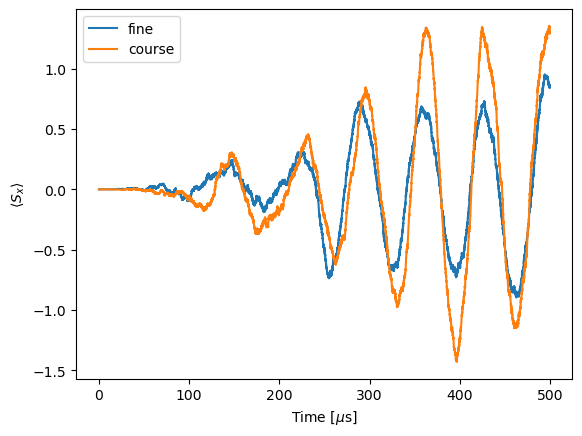

PyObject <matplotlib.legend.Legend object at 0x3886f7fa0>

In [109]:
plot(tout_fine, expect(Sx, psi_t_fine), label="fine")
plot(tout_course, expect(Sx, psi_t_course), label="course")
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()

In [99]:
W = WienerProcess(0.0, zeros(2), zeros(2))
prob = SDEProblem(sde_func, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=W)
sol1 = solve(prob, RKMilCommute();
            adaptive=true,
            abstol=1e-4,
            reltol=1e-4,
            dt=1//(2)^6,
            callback=scb, seed=seed, save_noise=true)

tout_RKMil = copy(out.t)
psi_t_RKMil = copy(out.saveval)

W2 = NoiseWrapper(sol1.W)
out2 = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out2,saveat=tspan,
                                         save_everystep=true,
                                         save_start = false,
                                         tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
prob2 = SDEProblem(sde_func, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=W2)
sol2 = solve(prob2, LambaEM();
            adaptive=true,
            abstol=1e-4,
            reltol=1e-4,
            dt=1//(2)^6,
            callback=scb, seed=seed, save_noise=true)
tout_EM = copy(out2.t)
psi_t_EM = copy(out2.saveval);

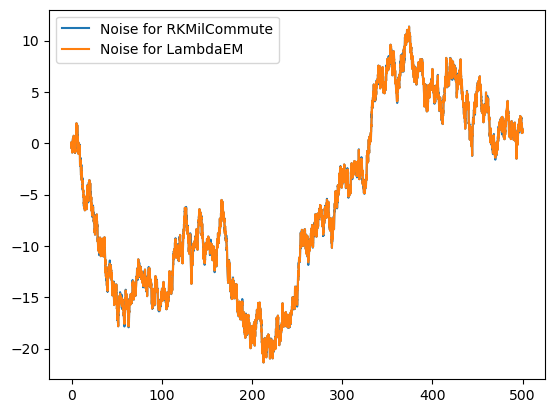

PyObject <matplotlib.legend.Legend object at 0x388497d60>

In [103]:
plot(sol1.W.t, map(x->x[1], sol1.W.u), label="Noise for RKMilCommute")
plot(sol2.W.t, map(x->x[1], sol2.W.u), label="Noise for LambdaEM")
legend()

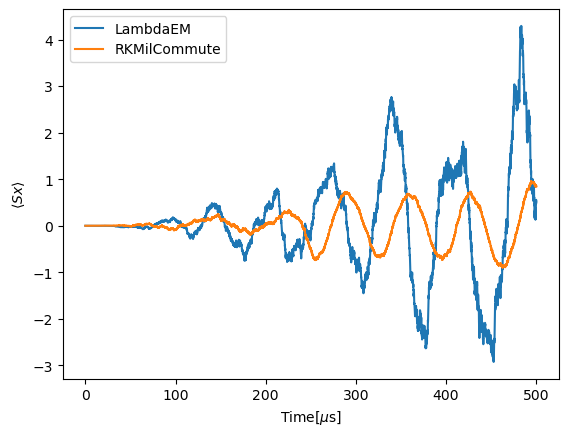

In [105]:
plot(tout_EM, expect(Sx, psi_t_EM), label="LambdaEM")
plot(tout_RKMil, expect(Sx, psi_t_RKMil), label="RKMilCommute")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
PyPlot.display_figs()